# Notebook 4
The purpose of this notebook is to a) train a machine learning model on vectorized review comments, b) determine which words carry the most weight when classifying listings as good or bad

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy import stats
import timeit

# Functions

In [37]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

def rm_outliers(df,col_name):
    '''
        Input: 
        df - dataframe with numerical values
        col_name - column with outliers
        
        output
        df - dataframe with outliers removed in col_name
        
        Description:
        Removes values which are > 2 * the standard deviation
        
    '''
    threshold = 2
    mean_col = df[col_name].mean()
    std_col  = df[col_name].std()
    df = df[abs(df[col_name] - mean_col)/std_col <= threshold]
    
    return df

def assign_category(rating,threshold_val):
    """
        Input: 
        rating - dataframe column with the rating score
        threshold_val - float which is used to define the good-bad listing cutoff score
    """
    if rating <= threshold_val:
        return 1
    else:
        return 0

In [38]:
#Import listings data
listings = pd.read_csv('listings.csv')
listings = listings[['id','review_scores_rating']]

#remove all rows where review_scores_rating is NaN
listings = listings.dropna(subset=['review_scores_rating'])

It is hard to define what a 'good' or 'bad' listing rating score is, because score is skewed towards high values. An appropriate definition might be the bottom 25% of listings, which corresponds to a score of 89 or below

In [39]:
listings['review_scores_rating'].quantile(0.25)

89.0

# Combining the data from the processed reviews and listings datasets

In [40]:
#Merge with reviews
reviews = pd.read_csv('reviews_processed.csv') #This is the processed review comments dataset generated in notebook 3
reviews = reviews.drop(columns=['date','reviewer_id','id',\
                                'reviewer_name','comments','review_cleaned'])

#Aggregate all comment word counts by listing id
reviews = reviews.groupby("listing_id",as_index=False).sum()

#Append review_scores_rating to listing ids that exist in reviews
listings_reviews = listings.merge(reviews,left_on='id', right_on='listing_id',how='inner')
listings_reviews = listings_reviews.drop(columns=['id','listing_id'])

In [41]:
listings_reviews.shape

(2772, 3247)

In [42]:
listings_reviews.head()

,review_scores_rating,reviewcomment_abbiamo,reviewcomment_aber,reviewcomment_abil,reviewcomment_abl,reviewcomment_abov,reviewcomment_abroad,reviewcomment_absolut,reviewcomment_abund,reviewcomment_ac,...,reviewcomment_zentrum,reviewcomment_zero,reviewcomment_zimmer,reviewcomment_zoe,reviewcomment_zona,reviewcomment_zone,reviewcomment_zu,reviewcomment_zum,reviewcomment_zur,reviewcomment_zwei
0,94.0,0,0,0,3,1,0,3,0,0,...,0,0,0,0,0,0,1,0,0,0
1,98.0,0,0,0,3,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,99.0,0,0,0,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training the model

I have decided to use the Random Forest classifier since it works well with categorical features.

A problem with defining 'bad' listings as being the bottom 25% of listings is that the bad : good ratio is about 1 : 3, which could lead to more false positives. To account for this, I separated out the 'bad' listings from the dataset, randomly sampled the same number of 'good' listings and created a dataset that had a 1:1 ratio of bad and good (This process is referred to as undersampling). To get an idea of the general accuracy range, I trained and tested 10 models on 10 datasets.

accuracy: 0.7800925925925926
f1: 0.7654320987654321


<Figure size 640x480 with 0 Axes>

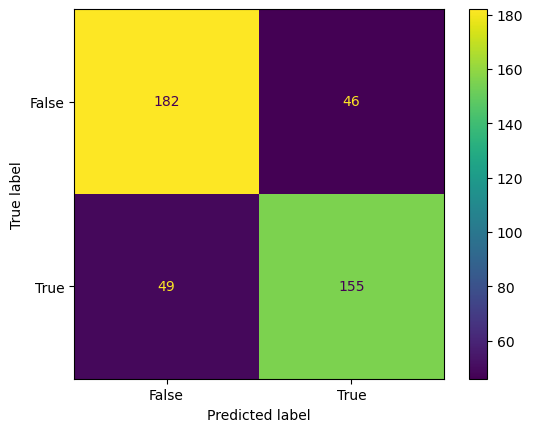

accuracy: 0.7731481481481481
f1: 0.7655502392344498


<Figure size 640x480 with 0 Axes>

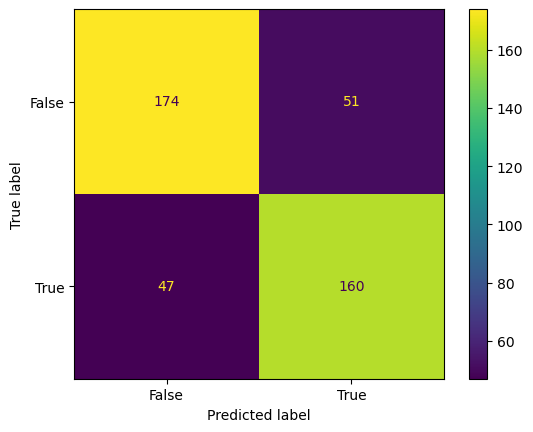

accuracy: 0.7546296296296297
f1: 0.7546296296296297


<Figure size 640x480 with 0 Axes>

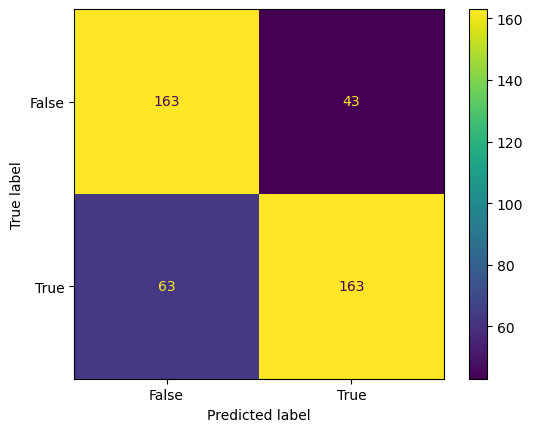

accuracy: 0.8171296296296297
f1: 0.8087167070217918


<Figure size 640x480 with 0 Axes>

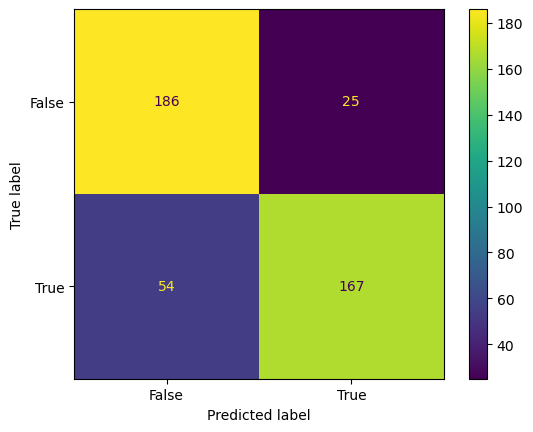

accuracy: 0.7800925925925926
f1: 0.7688564476885644


<Figure size 640x480 with 0 Axes>

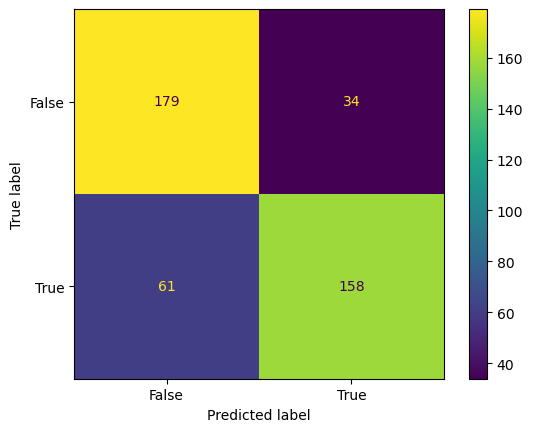

accuracy: 0.7268518518518519
f1: 0.702020202020202


<Figure size 640x480 with 0 Axes>

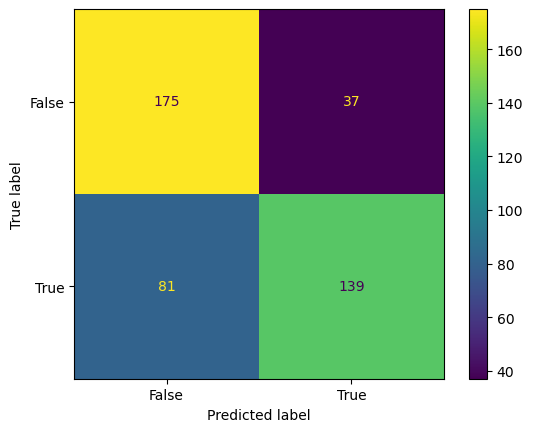

accuracy: 0.8240740740740741
f1: 0.8137254901960783


<Figure size 640x480 with 0 Axes>

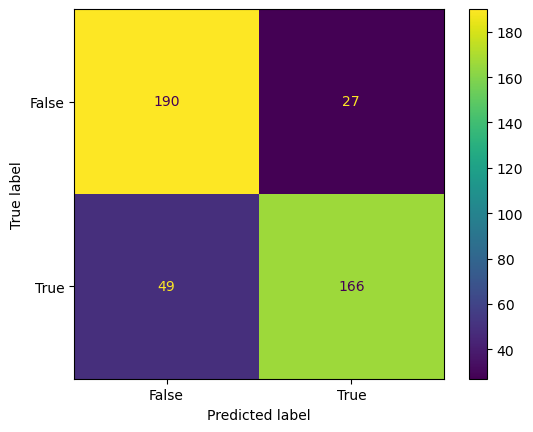

accuracy: 0.7939814814814815
f1: 0.7791563275434242


<Figure size 640x480 with 0 Axes>

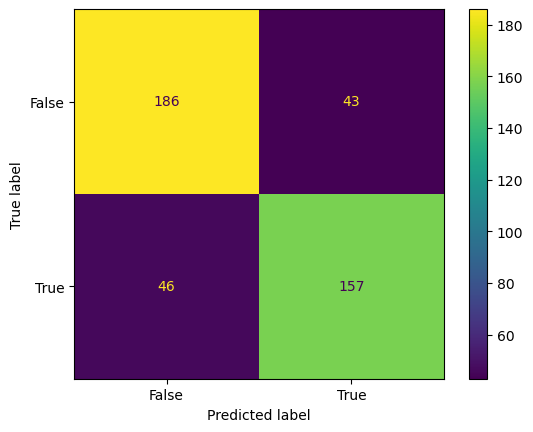

accuracy: 0.75
f1: 0.7352941176470589


<Figure size 640x480 with 0 Axes>

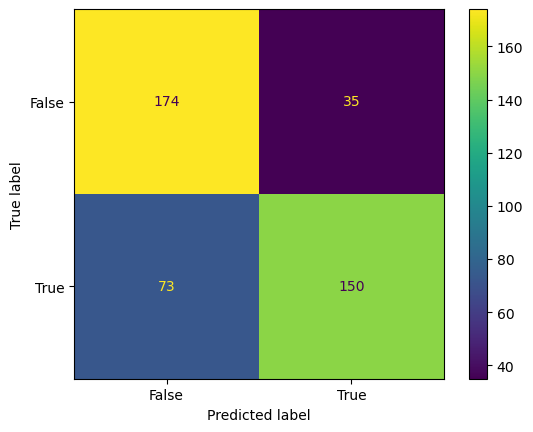

accuracy: 0.7685185185185185
f1: 0.7572815533980582


<Figure size 640x480 with 0 Axes>

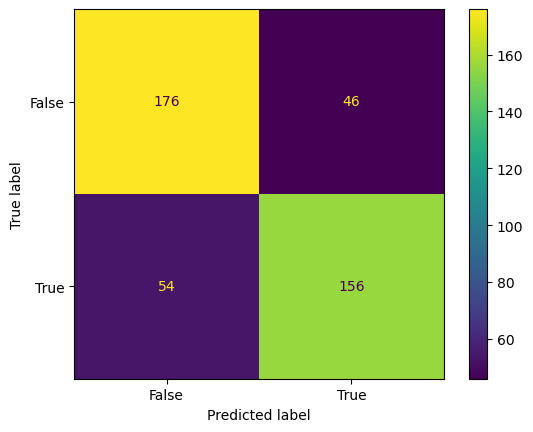

In [43]:
threshold_val = 89.0
lower_reviews = listings_reviews[listings_reviews['review_scores_rating']<=threshold_val] #'bad' listings

keys = [10,1,3,124,66,35,111,999,9,23] #Arbitrarily chosen random states
for i in range(len(keys)):
    
    upper_reviews = listings_reviews[listings_reviews['review_scores_rating']>threshold_val].sample(n=lower_reviews.shape[0], random_state=keys[i])
    reviews_for_training = pd.concat([lower_reviews,upper_reviews],axis=0) #create 50:50 dataset
    
    #Assign a label to each row based on review_scores_rating
    reviews_for_training['IS_LOWER_RATING'] = reviews_for_training['review_scores_rating'].apply(assign_category, threshold_val=threshold_val)
    reviews_for_training = reviews_for_training.drop(columns=['review_scores_rating'])
    
    y = reviews_for_training['IS_LOWER_RATING']
    X = reviews_for_training.drop(columns=['IS_LOWER_RATING'])
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=keys[i])
    clf = RandomForestClassifier(max_depth=100,n_estimators=100)
    
    #Fit and predict
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    #Sklearn confusion matrix:
    conf_matrix = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    precision = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
    recall = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
    print('accuracy: '+ str(accuracy_score(y_test,y_pred)))
    print('f1: ' + str((2*recall*precision)/(recall+precision)))
    plt.figure()
    cm_display.plot()
    plt.show()

# Determining the words of greatest importance for classification

In [44]:
feature_importances = clf.feature_importances_
feature_importances_df = pd.DataFrame({'Feature':X_train.columns,'Importance':feature_importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
feature_importances_df.head(20).reset_index()

,index,Feature,Importance
0,1285,reviewcomment_great,0.009786
1,108,reviewcomment_amaz,0.009144
2,2375,reviewcomment_recommend,0.008084
3,818,reviewcomment_dirti,0.006601
4,1735,reviewcomment_love,0.006372
5,293,reviewcomment_beauti,0.006117
6,1029,reviewcomment_everyth,0.006062
7,1394,reviewcomment_home,0.006032
8,3198,reviewcomment_wonder,0.005981
9,769,reviewcomment_definit,0.005828
